In [1]:
# Operaciones de archivos
import os
from os import listdir

import pickle
import zipfile
import shutil
from glob import glob

# Operaciones de datos
import pandas as pd
import numpy as np

# Operaciones de imágenes
from PIL import Image
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Visualización
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# Utilidades
import random
from time import time
import uuid
import re
import gc
from pprint import pprint
import itertools

## Comprensión Inicial de Imágenes

### Imágenes DICOM

Una imagen DICOM (Digital Imaging and Communications in Medicine) es un formato estándar utilizado en la industria de la salud para almacenar y transmitir imágenes médicas junto con la información asociada a ellas. Los archivos con la extensión .dcm contienen no solo la imagen digital (por ejemplo, de una radiografía, tomografía, resonancia magnética, etc.), sino también metadatos detallados como el nombre del paciente, la fecha del examen, el tipo de imagen, y otros datos importantes para el diagnóstico médico. DICOM permite la interoperabilidad entre diferentes sistemas y dispositivos médicos, garantizando que las imágenes puedan ser compartidas, visualizadas y procesadas por diferentes máquinas y softwares en hospitales y clínicas. Este formato ha sido fundamental para el desarrollo de la telemedicina y el análisis médico automatizado.

Referencias:
- DICOM. (s. f.). About DICOM- Overview. https://www.dicomstandard.org/about 
- Intelerad. (2024). What is DICOM Image Format & Why is It Important in Radiology? https://www.intelerad.com/en/2023/02/23/handling-dicom-medical-imaging-data/

### Metadata DICOM

In [2]:
# Seleccionar una de las imagenes de alguna carpeta
example_path = "data/train_images/1.2.826.0.1.3680043.14/1.dcm"

dcm_example = pydicom.dcmread(example_path)
display(dcm_example)

Dataset.file_meta -------------------------------
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.14.1.1
(0002,0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008,0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.14.1.1
(0008,0023) Content Date                        DA: '20220727'
(0008,0033) Content Time                        TM: '180841.008575'
(0010,0010) Patient's Name                      PN: '14'
(0010,0020) Patient ID                          LO: '14'
(0018,0050) Slice Thickness                     DS: '0.6'
(0020,000D) Study Instance 

Los datos de la tomografía se almacenan en un array bajo el nombre de **Pixel Data**. Todo lo demas son metadatos relacionados. 

Algunos de los mas relevantes a tomar en cuenta son:

- `Rows`: La altura de la imagen o tomografía.
- `Columns`: El ancho de la imagen o tomografía.
- `SOPInstanceUID`: Identificador único que contiene el `StudyInstanceUID` más el número de corte.
- `ContentDate`: La fecha en que comenzó la creación de los datos de píxeles de la imagen.
- `SliceThickness`: Indica el grosor de la sección de imagen.
- `InstanceNumber`: Número de corte.
- `ImagePositionPatient`: Las coordenadas x, y, y z de la esquina superior izquierda (centro del primer voxel transmitido) de la imagen, en mm.
- `ImageOrientationPatient`: Los cosenos directores de la primera fila y la primera columna con respecto al paciente.
- `Pixel Data`: Los datos de la imagen se almacenan en una matriz.
- `Pixel Spacing`: Espaciado entre los píxeles.
- `Window Center`: Información sobre el brillo de la imagen.
- `Window Width`: Información sobre el contraste de la imagen.
- `Rescale Intercept`: Determina el rango de los valores de los píxeles (intercepto).
- `Rescale Slope`: Determina el rango de los valores de los píxeles (pendiente).

La combinación de los atributos `Rows` y `Columns` proporciona el tamaño de la imagen, mientras que `Pixel Spacing` y `SliceThickness` indican el tamaño de los píxeles y el grosor de los cortes. `Window Center` y `Window Width` proporcionan la información sobre el brillo y el contraste de la imagen. `ImagePositionPatient` da las coordenadas x, y, z de la esquina superior izquierda de cada imagen en mm. `InstanceNumber` corresponde al número de corte.

Si desea saber mas sobre el resto de atributos de la tomografía puede visitar el siguiente enlace:
- https://dicom.innolitics.com/ciods/ct-image

### Muestreo de Tomografías

#### Funciones Auxiliares

In [3]:
def atoi(text):
    """
    Convierte texto a entero si es posible, 
    de lo contrario devuelve el texto original.

    Args:
        text (str): Texto a convertir

    Returns:
        int: Texto convertido a entero si es posible
    """
    return int(text) if text.isdigit() else text

In [4]:
def natural_keys(text):
    """
    Clave de ordenación para ordenar alfanuméricamente.

    Args:
        text (str): Cadena de texto.

    Returns:
        list: Lista de enteros y texto
    """
    return [atoi(c) for c in re.split(r'(\d+)', text)]

In [5]:
def get_subfolder_names(folder_path):
    """
    Obtiene los nombres de todas las subcarpetas en una carpeta dada.

    Args:
        folder_path (str): Ruta de la carpeta principal.

    Returns:
        list: Lista con los nombres de las subcarpetas.
    """
    return [name for name in listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

In [6]:
studies_ids = get_subfolder_names("data/train_images")

#### Visualización

In [7]:
def show_dcm_slices(scan_id, base_path="data", rows=2, cols=4):
    """
    Muestra una selección de imágenes de un estudio dado en formato DICOM.

    Args:
        base_path (str): Ruta base de los datos.
        scan_id (str): ID del estudio a visualizar.

    Returns:
        None
    """
    

    dcm_paths = glob(f"{base_path}/train_images/{scan_id}/*")

    # Obtener las imágenes
    files = [pydicom.dcmread(path) for path in dcm_paths]
    images = [apply_voi_lut(file.pixel_array, file) for file in files]
    dcm_to_show = rows * cols

    if len(images) < dcm_to_show:
        raise ValueError(f"El estudio {scan_id} tiene menos de {dcm_to_show} imágenes.")
    
    # Seleccionar las imágenes a mostrar aleatoriamente
    selected_indices = random.sample(range(len(images)), dcm_to_show)
    selected_indices.sort()

    # Graficar las imágenes
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24,12))
    fig.suptitle(f"Muestreo de Tomografías para el \n Estudio con ID: {scan_id}", 
                 weight="bold", 
                 size=25)

    # Iterar sobre las imágenes seleccionadas
    for idx, ax in zip(selected_indices, axes.flat):
        img = images[idx]
        file = files[idx]
        slice_no = idx

        # Mostrar la imagen
        ax.imshow(img, cmap="bone")
        ax.set_title(f"Corte: {slice_no}", fontsize=14, weight='bold')
        ax.axis('off')

    plt.show()

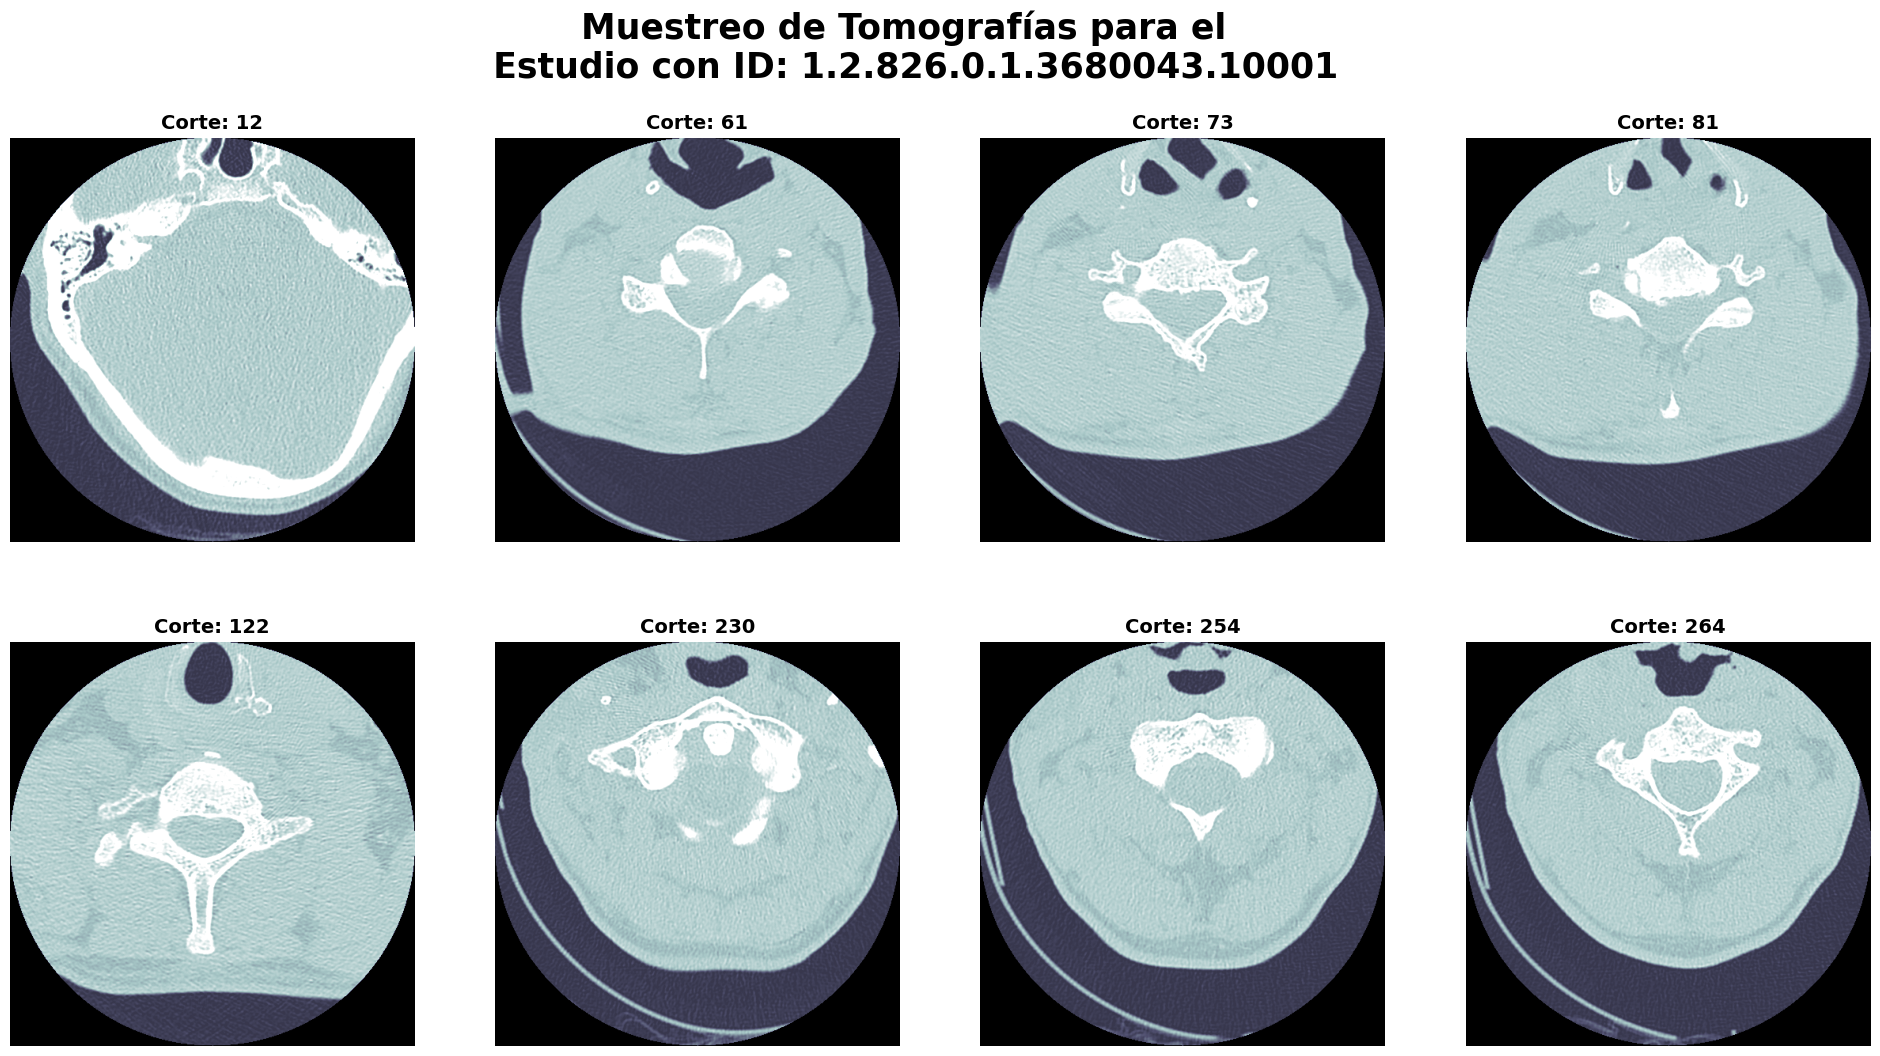

In [8]:
show_dcm_slices(studies_ids[0])

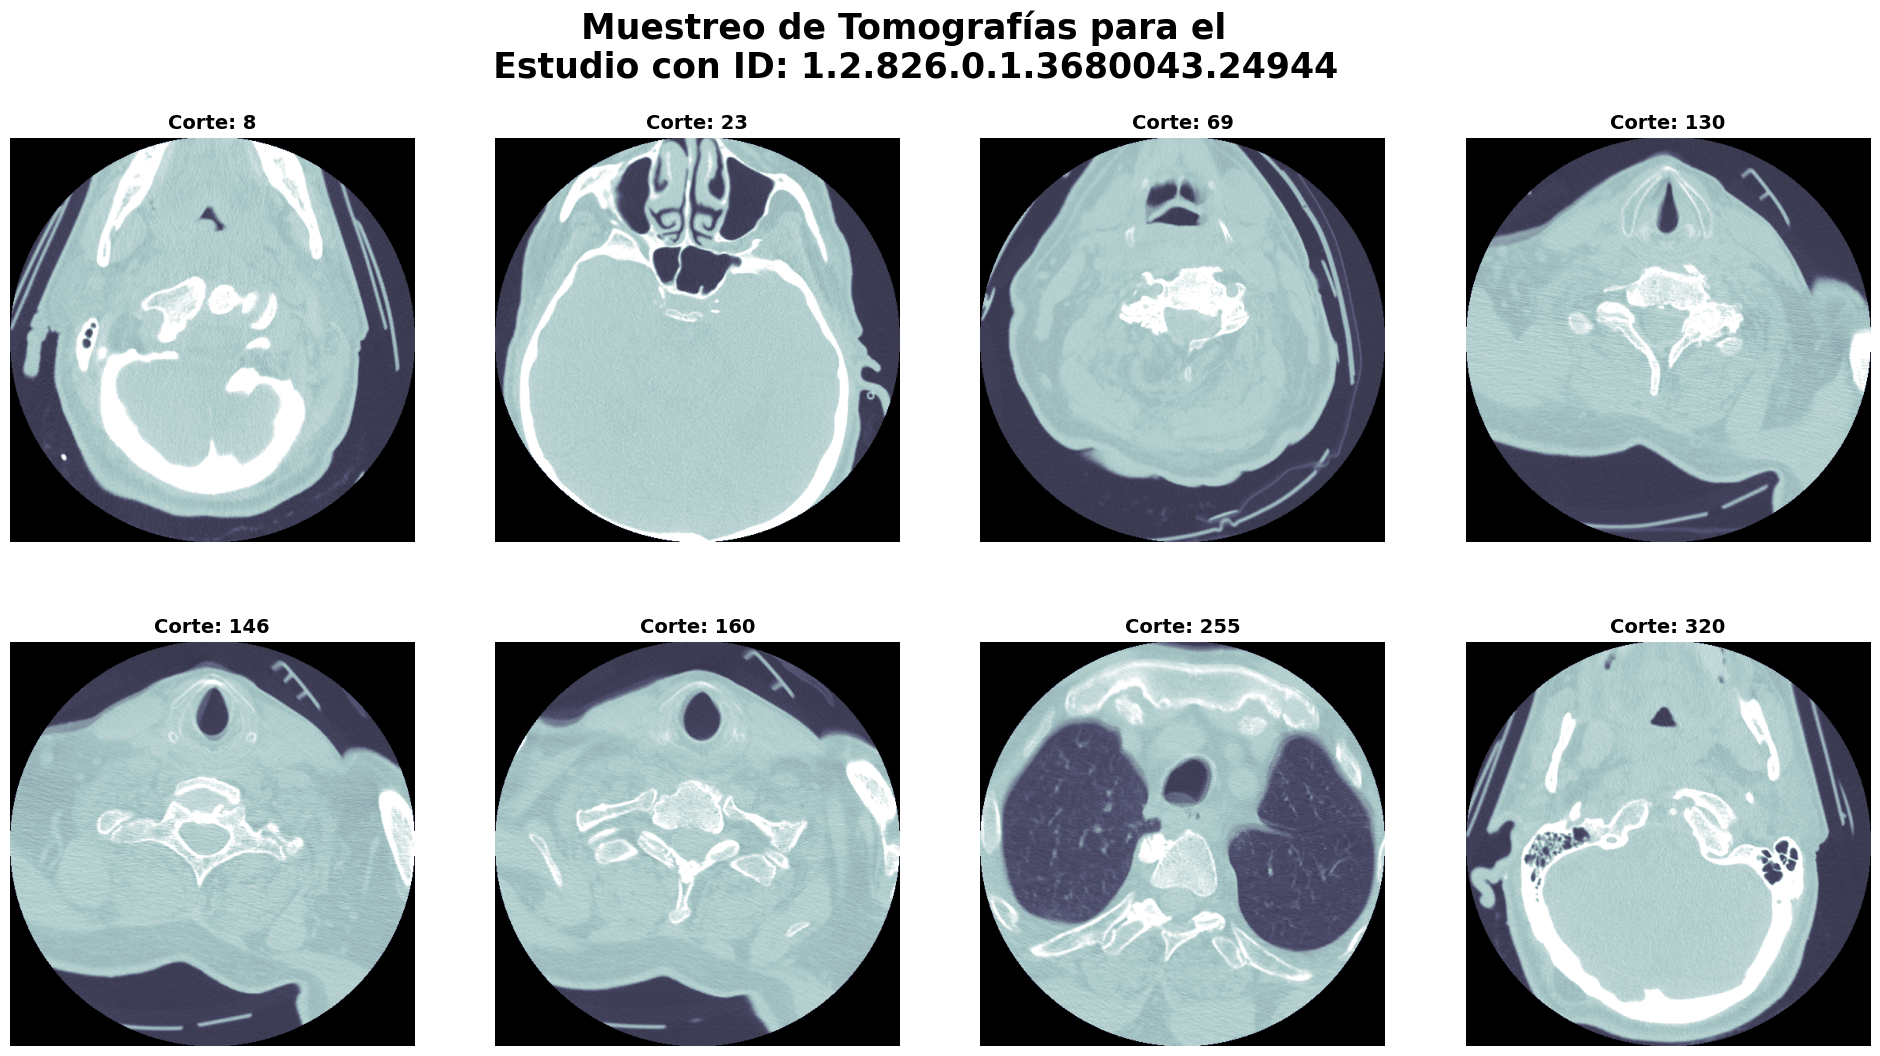

In [9]:
random_study = random.choice(studies_ids)
show_dcm_slices(random_study)

A partir de las tomografías mostradas, se observan cortes axiales centrados en la región cervical y posiblemente torácica. En el centro de las imágenes se distingue una vértebra, aunque no es posible identificar con precisión cuál es sin información adicional. Los hallazgos generales incluyen una visualización clara de la vértebra bien definidos. Sin embargo, sin marcadores anatómicos o información de referencia, no es posible determinar con exactitud el nivel vertebral de los cortes. Algunas imágenes parecen incluir partes del cráneo, lo que indica que el estudio podría abarcar la región del cuello y la base del cráneo.